# problem set 2
Wrriten by Shogo Nakano

HOMEWORK ASSIGNMENT 2

Please perform the following exercises for the mobile robot problem under the policies

* "always try to go right"
* "always try to go left" and
* "tries to go left" with 50% probability and "tries to go right" with 50% probability 50% probability

1) Construct the transition probability matrix. Enumerate the states from left to right (0 to 20).

2) Group all states into classes. Report the classes and the total number of classes. Explain your answer.

3) Construct a 1000-step simulation assuming the mobile robot always starts in the middle segment.

* Plot the sequence of transitions as a step function of time for the first 100 steps.
* Report the likehood of each transition and the likelihood of the first 100 steps.
* Is this Markov chain stationary? Please provide detailed reasoning.
* Is this Markov chain time homogeneous? Please provide detailed reasoning.

4) Based on the simulated data, estimate the transition probabilities and compare with the actual transition probabilities.

5) Plot the n-step ahead probabilities for each transition for the first 100 steps.

## Set up

In [1]:
import numpy as np
import pandas as pd
import gym # use gymnasium followed documentation
from gym import spaces
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})

%matplotlib inline

pd.set_option('display.max_columns', None)

#### Environment

In [2]:
# define class Segment
class Segment:
    def __init__(self, numActions, startObservation, p, terminal, done):
        self.numActions = numActions
        self.observation = startObservation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.numActions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2*self.terminal+1) # terminal means the length to the terminal
        self.done = done
        
    def step(self, action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation != 0
        assert self.observation != (2*self.terminal)
        observation = self.observation
        done = self.done
        
        if action==0:
            observation_next = observation + np.random.choice([-1, 1],p=[self.p, 1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1, 1],p=[1-self.p, self.p])
            
        if observation_next == (2*self.terminal):
            done = True
        elif observation_next == 0:
            done = True
            
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation, observation_next, action)
        return [self.observation, reward, done]
    
    def rewards(self, observation, observation_next, action):
        if observation_next==(2*self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    
    def reset(self):
        observation = self.startObservation
        self.observation = observation
        self.done =False
        return observation

In [3]:
# run multiple episodes
def run_multi_episodes(policy):
    allEpisodes = pd.DataFrame()

    for e in range(0,1000):
        # compute discount reward
        t=0
        tMAX = 1000
        done = False
        observation = 10
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2, startObservation=10, p=0.8, terminal=10, done=False)

        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1

        # get dataframe like table 2.1
        dta = pd.DataFrame(
                     [[e]*t,
                      range(0,t),
                      observations[0:t],
                      observations[1:(t+1)],
                      actions[0:t],
                      rewards]).transpose()
        dta.columns = ['episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'].astype(int)
        dta['observation_next'] = dta['observation_next'].astype(int)
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']

        allEpisodes = pd.concat([allEpisodes, dta])
        
    return allEpisodes

## (1) under the "Always try to go right policy"

#### Policy

In [4]:
def policy_right(observation):
    action = 1
    return action

#### 1. Transition Matrix

Text(0.5, 1.0, 'Transition Matrix for Always Right Policy')

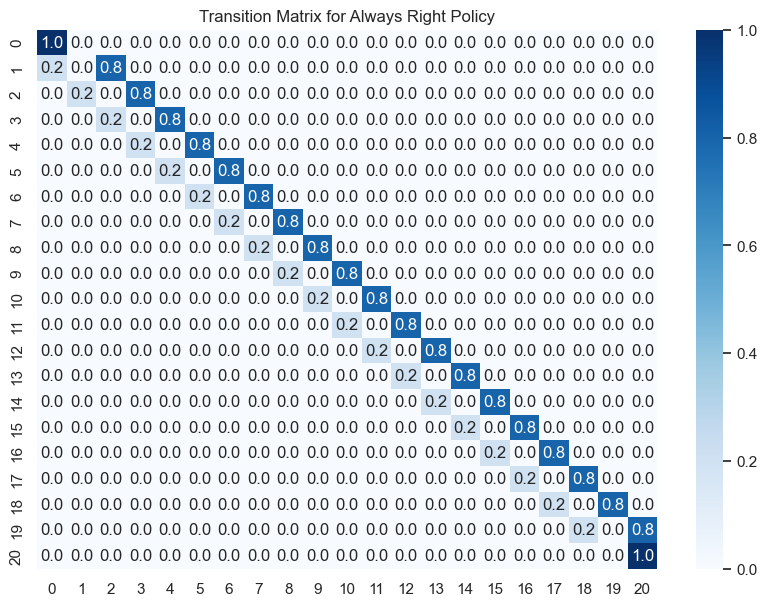

In [5]:
# get transition matrix
transition_matrix_right = np.zeros((21,21))

for i in range(1,20):
    transition_matrix_right[i,i-1] = 0.2
    transition_matrix_right[i,i+1] = 0.8

transition_matrix_right[0,0] = 1
transition_matrix_right[20,20] = 1

# plot transition matrix as heatmap
sns.heatmap(transition_matrix_right, cmap='Blues', annot=True, fmt='.1f')
# set title
plt.title('Transition Matrix for Always Right Policy')

#### 2. classes

There are three classes. 

class 1 : [0] \
class 2 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] \
class 3 : [20] 

Any two states that communicate are said to belong to the same class, and communication \
means that they are both accessible to each other.

In this process, from state 1 to state 19, every states communicate each other.\
However, state 0 is accessible from state 1, but state 1 is not accessible from state 0.\
Also, state 20 is accessible from state 19, but state 19 is not accessible from state 20. 


#### 3. simulation

In [6]:
# run 1000 times
df = run_multi_episodes(policy=policy_right)

# get probability of each step
df['probability'] = transition_matrix_right[df['observation'], df['observation_next']]

# cumulative probability
df['cumulative_probability'] = df.groupby(['episode'])['probability'].cumprod()

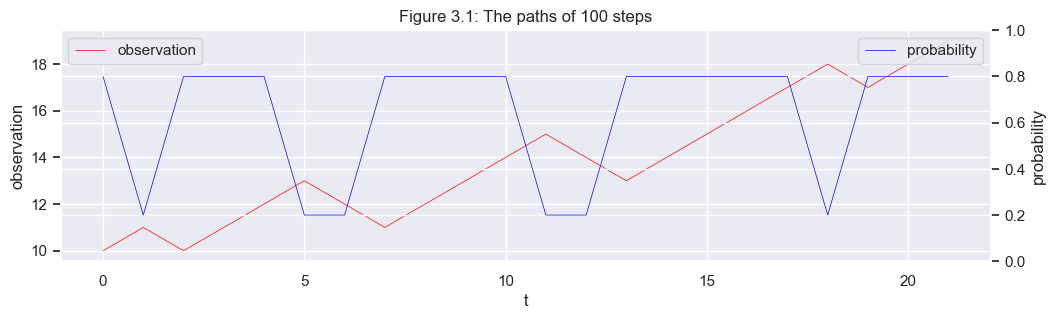

In [7]:
# Plot the sequence of transitions as a step function of time for the first 100 steps.
# The x-axis is time, the y-axis is the state, and the step function is the action.
def plot_100steps(df):
    d = df[(df['t']>=0) & (df['t']<=100) & (df['episode']==0)]
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    ax2 = ax1.twinx()
    
    sns.lineplot(x='t', y='observation',data=d, ax=ax1, color='red', legend=True, linewidth=0.5,label='observation')
    #ax1.set_xlim(0,100)
    
    sns.lineplot(x='t', y='probability', color='blue',data=d, ax=ax2, legend=True, linewidth=0.5, label='probability')
    #ax2.set_xlim(0,100)
    ax2.set_ylim(0,1)

    # set title
    plt.title('Figure 3.1: The paths of 100 steps')

plot_100steps(df)

In [8]:
# plot cumulative probability
def plot_cumulative_probability(df):
    fig = plt.figure(figsize=(12,3))
    df_0_100 = df[(df['episode']==0)] #df[(df['episode']>=0) & (df['episode']<=100)]
    sns.lineplot(x='t', y='cumulative_probability', color='red' ,data=df_0_100, legend=False, linewidth=0.5)
    # set title
    plt.title('Figure 3.2: The cumulative probabilities of 100 steps')

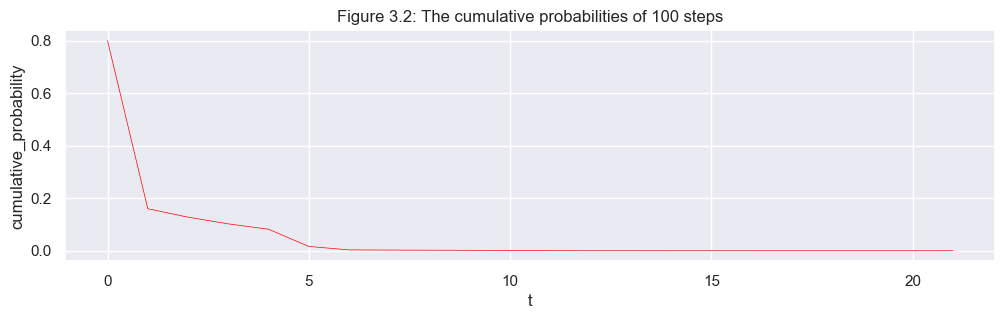

In [9]:
plot_cumulative_probability(df)

* Is this Markov chain stationary? Please provide detailed reasoning.

        It is not stationary. Its initial state is always mid-point = 10 and this makes this process time dependent.
        For example, at t=1, P(Y=20) = 0. However, at t =10, P(Y=20) = 0.8^10. 

* Is this Markov chain time homogeneous? Please provide detailed reasoning.

        Yes, it is a time homgeneous markov chain. The definition of time homogeneous is "with stationary transition 
        probabilities." The probability transition matrix of this process does not change over time, thus it meets
        the definition. 
        

#### Check stationary

In [10]:
# 21 zeros numpy array, only 10th element is 1
p = np.zeros(21)
p[10] = 1

np.array_equal(p, p.dot(transition_matrix_right))

False

#### 4. Simulated transiton matrix

In [11]:
def simulate_transition_matrix(df, transition_matrix):
    # range
    min_pos = 0
    max_pos = 20
    # define
    transition_df = df[['observation', 'observation_next']].dropna()
    # count
    counts = transition_df.groupby(['observation', 'observation_next']).size().unstack(fill_value=0)
    # compute probability
    probabilities = counts.div(counts.sum(axis=1), axis=0)
    # fill zero if not exist
    probabilities = probabilities.reindex(index=range(min_pos, max_pos+1), columns=range(min_pos, max_pos+1), fill_value=0)
    # return dataframe
    probabilities.iloc[0,0]=1
    probabilities.iloc[20,20]=1
    
    # two plots
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    # plot simulated matrix
    sns.heatmap(probabilities, cmap='Blues', annot=True, fmt='.1f', ax=axes[0], annot_kws={"size": 6})
    # ax title
    axes[0].set_title('simulated transition probability matrix')

    # plot transition matrix
    sns.heatmap(transition_matrix, cmap='Blues', annot=True, fmt='.1f', ax=axes[1], annot_kws={"size": 6})
    # ax title
    axes[1].set_title('transition probability matrix')

    # title
    plt.suptitle('Figure 3.3: Simulated transition probability matrix and transition probability matrix')
    plt.show()

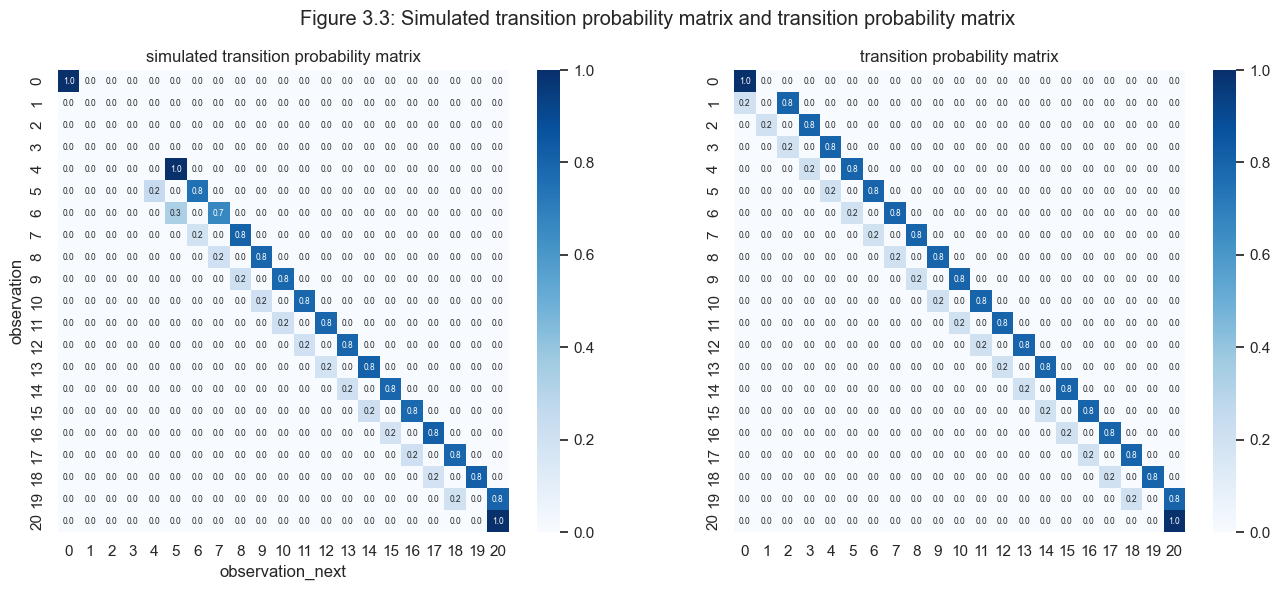

In [12]:
simulate_transition_matrix(df, transition_matrix_right)

It seems that the robot did not reach state 1 to 4 because the probability is too low.

#### n-step transition probability

In [13]:
# get n-step forward probability
def get_nstep_probability(transition_matrix):
    T = 1000
    n = 21
    P = np.zeros((T,n,n),dtype=np.float64)
    Pmat = transition_matrix

    P[0] = Pmat

    P[0] = Pmat
    for t in range(1,T-1):
        P[t] = np.matmul(P[t-1],Pmat)
    
    return P

In [14]:
nstep_probability_right = get_nstep_probability(transition_matrix_right)

In [15]:
def nstep_matrix(data):
    steps = [0, 1, 2, 3, 5, 10, 20, 50, 100]
    fig, axes = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
    
    for i, ax in zip(steps, axes.flatten()):
        sns.heatmap(data[i, :, :], cmap='Blues', annot=True, fmt='.1f', ax=ax, annot_kws={"size": 5})
        ax.set_title(f'{i}-step Transition Matrix')
    
    plt.tight_layout()
    plt.show()


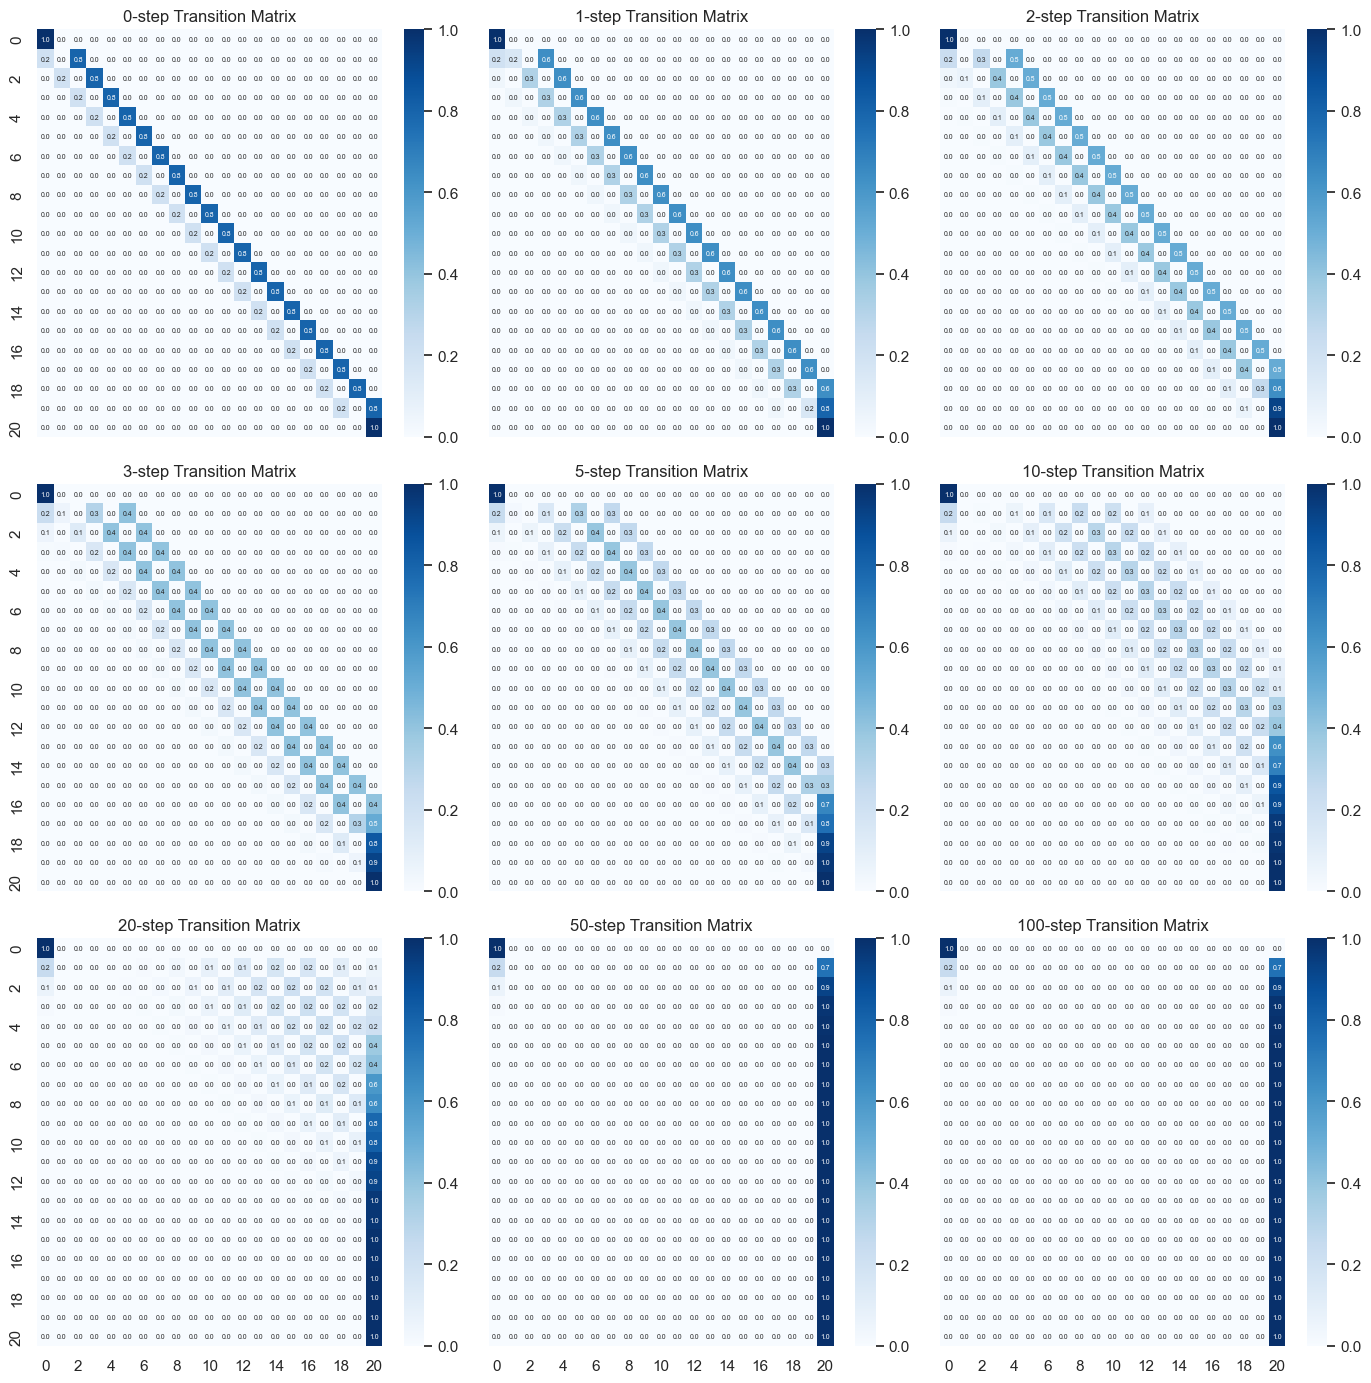

In [16]:
nstep_matrix(nstep_probability_right)

The probability to go to state 20 becomes higher.

## (2)  under the "Always try to go left policy"

#### Policy

In [17]:
def policy_left(observation):
    action = 0
    return action

#### 1. Transition Matrix

Text(0.5, 1.0, 'Transition Matrix for Always left Policy')

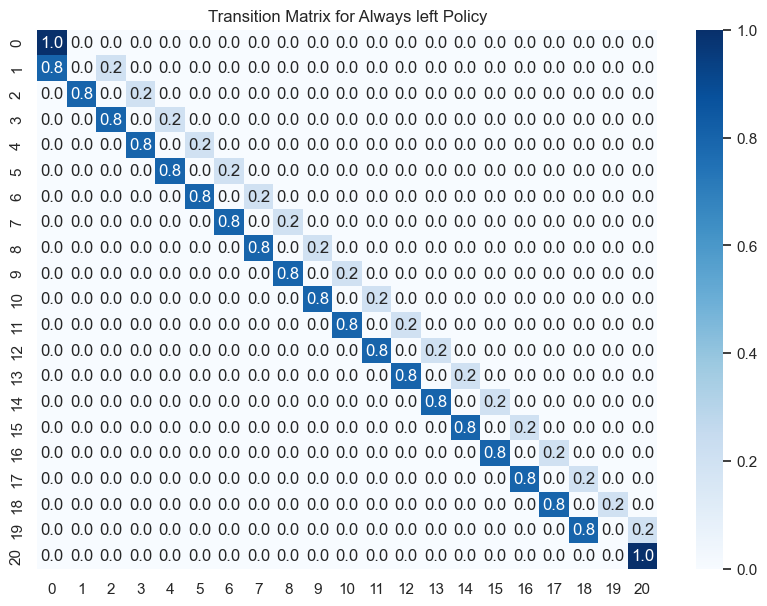

In [18]:
# get transition matrix
transition_matrix_left = np.zeros((21,21))

for i in range(1,20):
    transition_matrix_left[i,i-1] = 0.8
    transition_matrix_left[i,i+1] = 0.2

transition_matrix_left[0,0] = 1
transition_matrix_left[20,20] = 1

# plot transition matrix as heatmap
sns.heatmap(transition_matrix_left, cmap='Blues', annot=True, fmt='.1f')
# set title
plt.title('Transition Matrix for Always left Policy')

#### 2. classes

There are three classes. 

class 1 : [0] \
class 2 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] \
class 3 : [20] 

Any two states that communicate are said to belong to the same class, and communication \
means that they are both accessible to each other.

In this process, from state 1 to state 19, every states communicate each other.\
However, state 0 is accessible from state 1, but state 1 is not accessible from state 0.\
Also, state 20 is accessible from state 19, but state 19 is not accessible from state 20. 


#### 3. simulation

In [19]:
# run 1000 times
df = run_multi_episodes(policy=policy_left)
# get probability of each step
df['probability'] = transition_matrix_left[df['observation'], df['observation_next']]

# cumulative probability
df['cumulative_probability'] = df.groupby(['episode'])['probability'].cumprod()

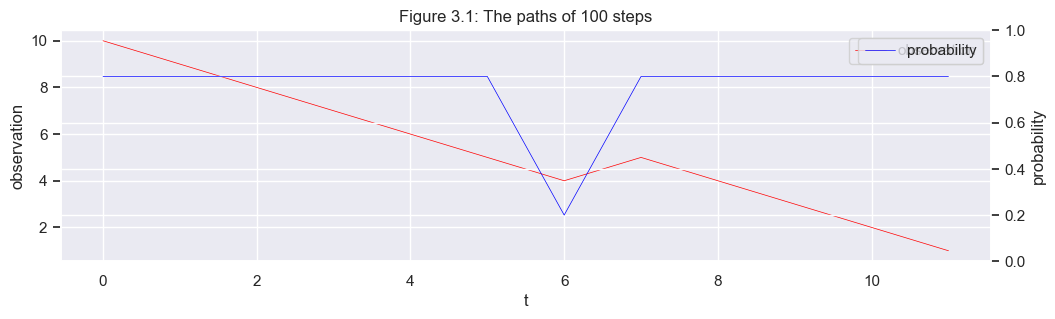

In [20]:
plot_100steps(df)

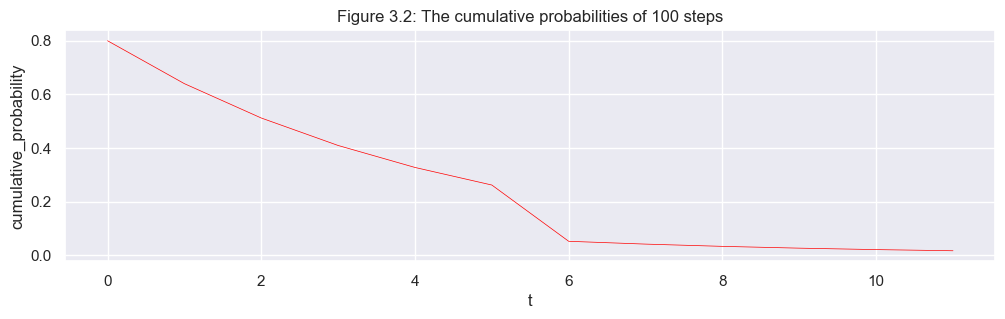

In [21]:
plot_cumulative_probability(df)

* Is this Markov chain stationary? Please provide detailed reasoning.

        It is not stationary. Its initial state is always mid-point = 10 and this makes this process time dependent.
        For example, at t=1, P(Y=20) = 0. However, at t =10, P(Y=0) = 0.8^10. 

* Is this Markov chain time homogeneous? Please provide detailed reasoning.

        Yes, it is a time homgeneous markov chain. The definition of time homogeneous is "with stationary transition 
        probabilities." The probability transition matrix of this process does not change over time, thus it meets
        the definition. 
        

#### Check stationary

In [22]:
# 21 zeros numpy array, only 10th element is 1
p = np.zeros(21)
p[10] = 1

np.array_equal(p, p.dot(transition_matrix_left))

False

#### 4. Simulated transiton matrix

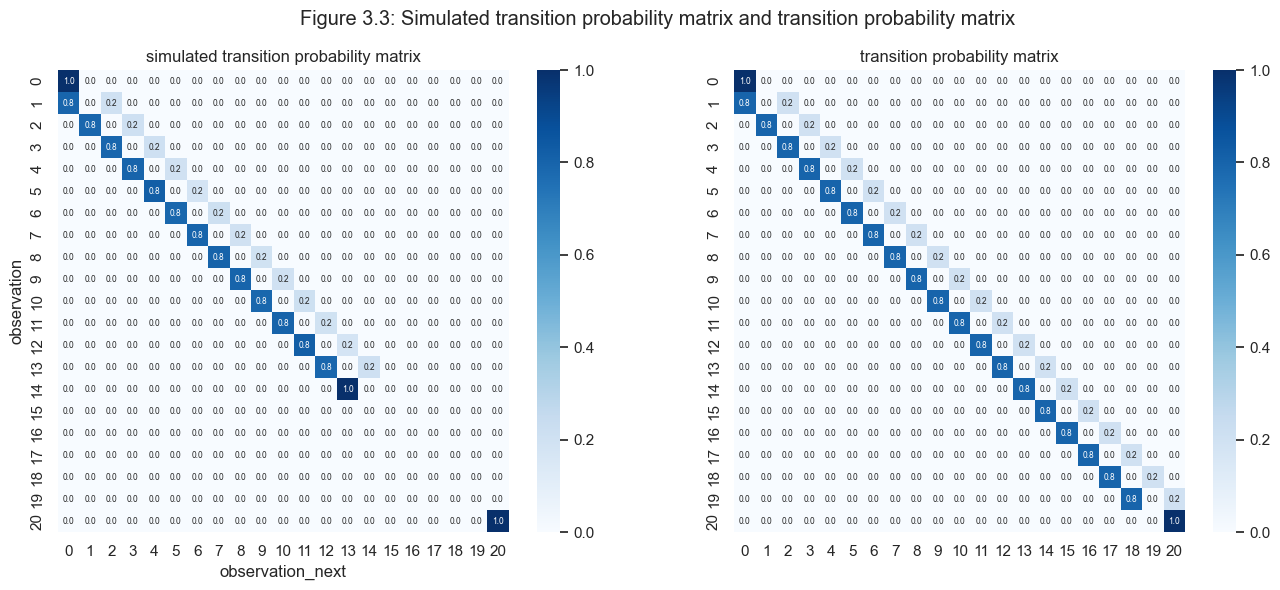

In [23]:
simulate_transition_matrix(df, transition_matrix_left)

In simulation, the robots did not reach 15 to 19.

#### n-step transition probability

In [24]:
nstep_probability_left = get_nstep_probability(transition_matrix_left)

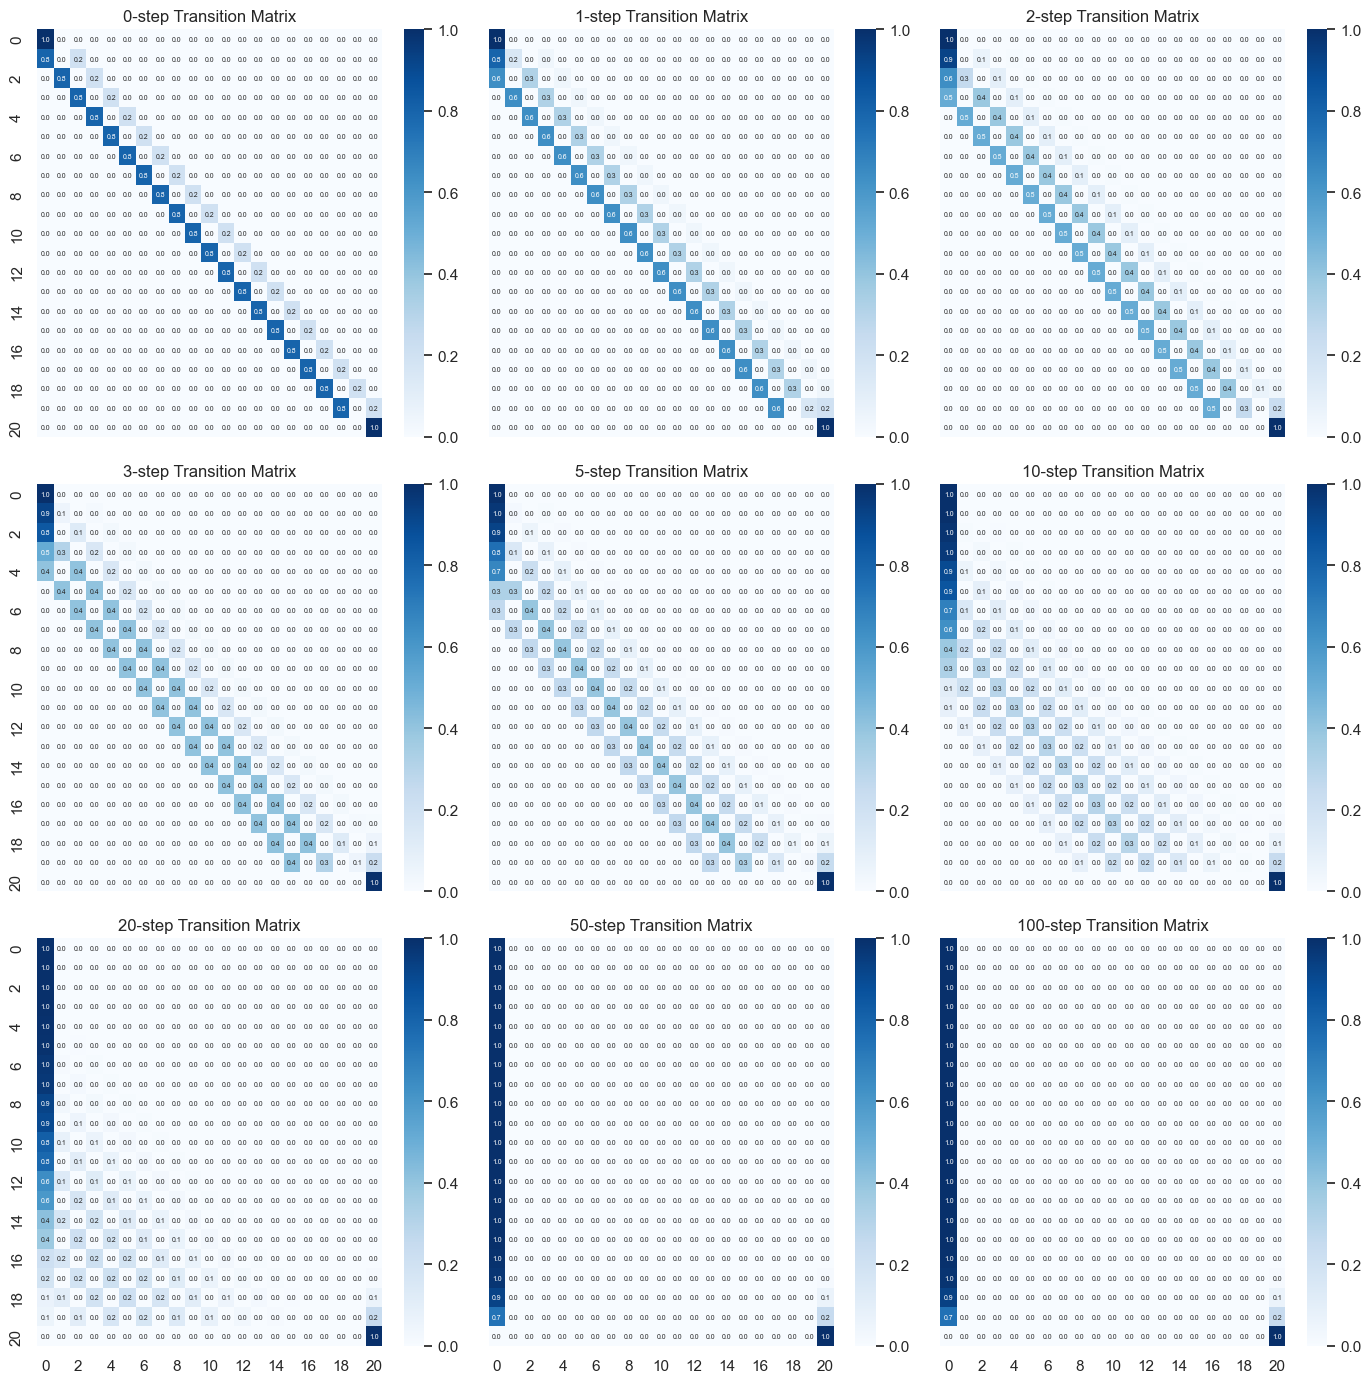

In [25]:
nstep_matrix(nstep_probability_left)

The probability to go to state 0 becomes higher.

## (3)  under the "50-50 policy"

#### Policy

In [26]:
def policy_50(observation):
    action = np.random.choice([0, 1], p=[0.5, 0.5])
    return action

#### 1. Transition Matrix

Text(0.5, 1.0, 'Transition Matrix for 50-50 Policy')

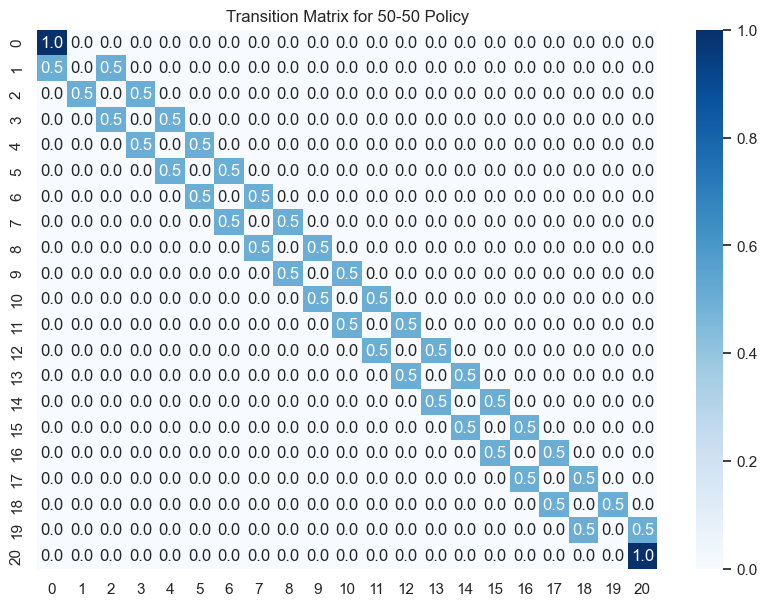

In [27]:
# get transition matrix
transition_matrix_50 = np.zeros((21,21))

for i in range(1,20):
    transition_matrix_50[i,i-1] = 0.5
    transition_matrix_50[i,i+1] = 0.5

transition_matrix_50[0,0] = 1
transition_matrix_50[20,20] = 1

# plot transition matrix as heatmap
sns.heatmap(transition_matrix_50, cmap='Blues', annot=True, fmt='.1f')
# set title
plt.title('Transition Matrix for 50-50 Policy')

#### 2. classes

There are three classes. 

class 1 : [0] \
class 2 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] \
class 3 : [20] 

Any two states that communicate are said to belong to the same class, and communication \
means that they are both accessible to each other.

In this process, from state 1 to state 19, every states communicate each other.\
However, state 0 is accessible from state 1, but state 1 is not accessible from state 0.\
Also, state 20 is accessible from state 19, but state 19 is not accessible from state 20. 


#### 3. simulation

In [28]:
# run 1000 times
df = run_multi_episodes(policy=policy_50)

# get probability of each step
df['probability'] = transition_matrix_50[df['observation'], df['observation_next']]

# cumulative probability
df['cumulative_probability'] = df.groupby(['episode'])['probability'].cumprod()

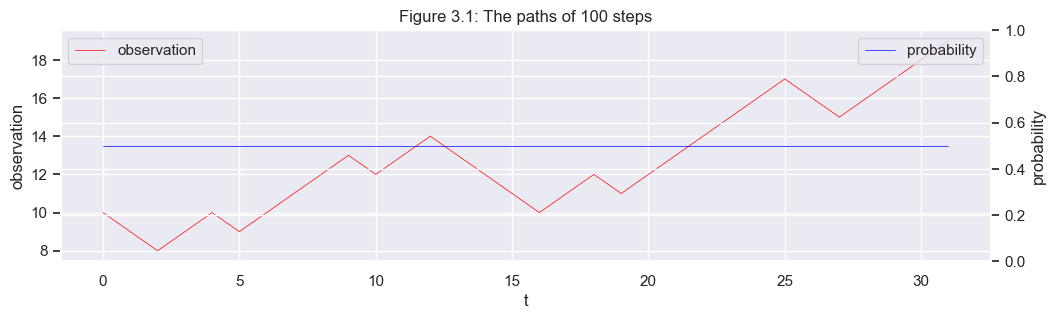

In [29]:
# Plot the sequence of transitions as a step function of time for the first 100 steps.
# The x-axis is time, the y-axis is the state, and the step function is the action.
plot_100steps(df)

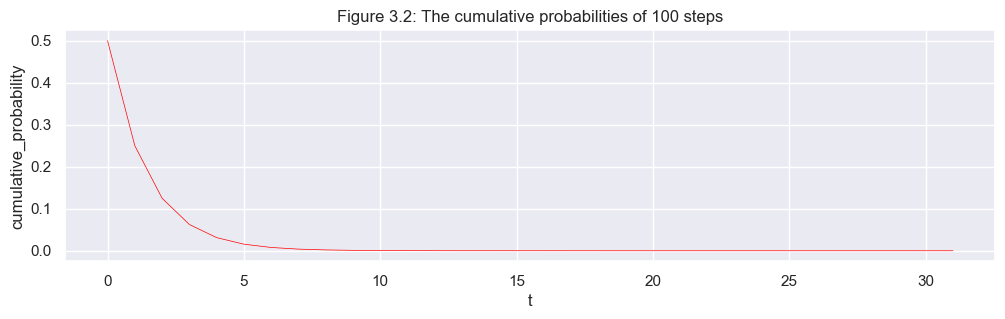

In [30]:
plot_cumulative_probability(df)

* Is this Markov chain stationary? Please provide detailed reasoning.

        It is not stationary. Its initial state is always mid-point = 10 and this makes this process time dependent.
        For example, at t=1, P(Y=20) = 0. However, at t =10, P(Y=20) = 0.5^10. 

* Is this Markov chain time homogeneous? Please provide detailed reasoning.

        Yes, it is a time homgeneous markov chain. The definition of time homogeneous is "with stationary transition 
        probabilities." The probability transition matrix of this process does not change over time, thus it meets
        the definition. 
        

#### Check stationary

In [31]:
# 21 zeros numpy array, only 10th element is 1
p = np.zeros(21)
p[10] = 1

np.array_equal(p, p.dot(transition_matrix_50))

False

#### 4. Simulated transiton matrix

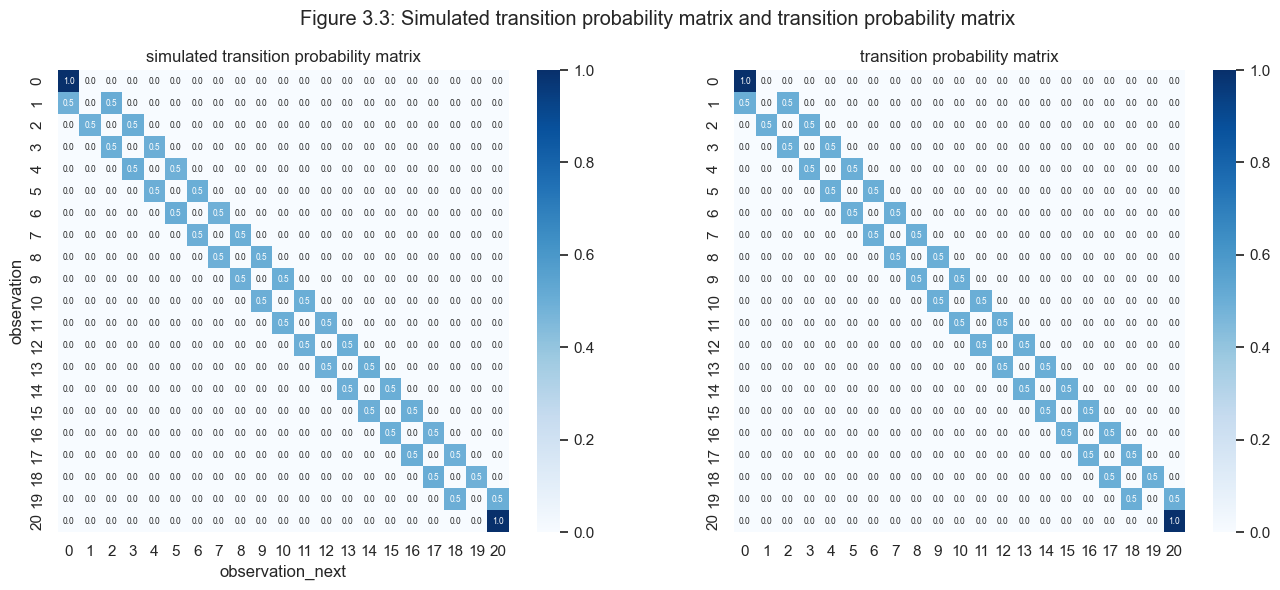

In [32]:
simulate_transition_matrix(df, transition_matrix_50)

#### n-step transition probability

In [33]:
nstep_probability_50 = get_nstep_probability(transition_matrix_50)

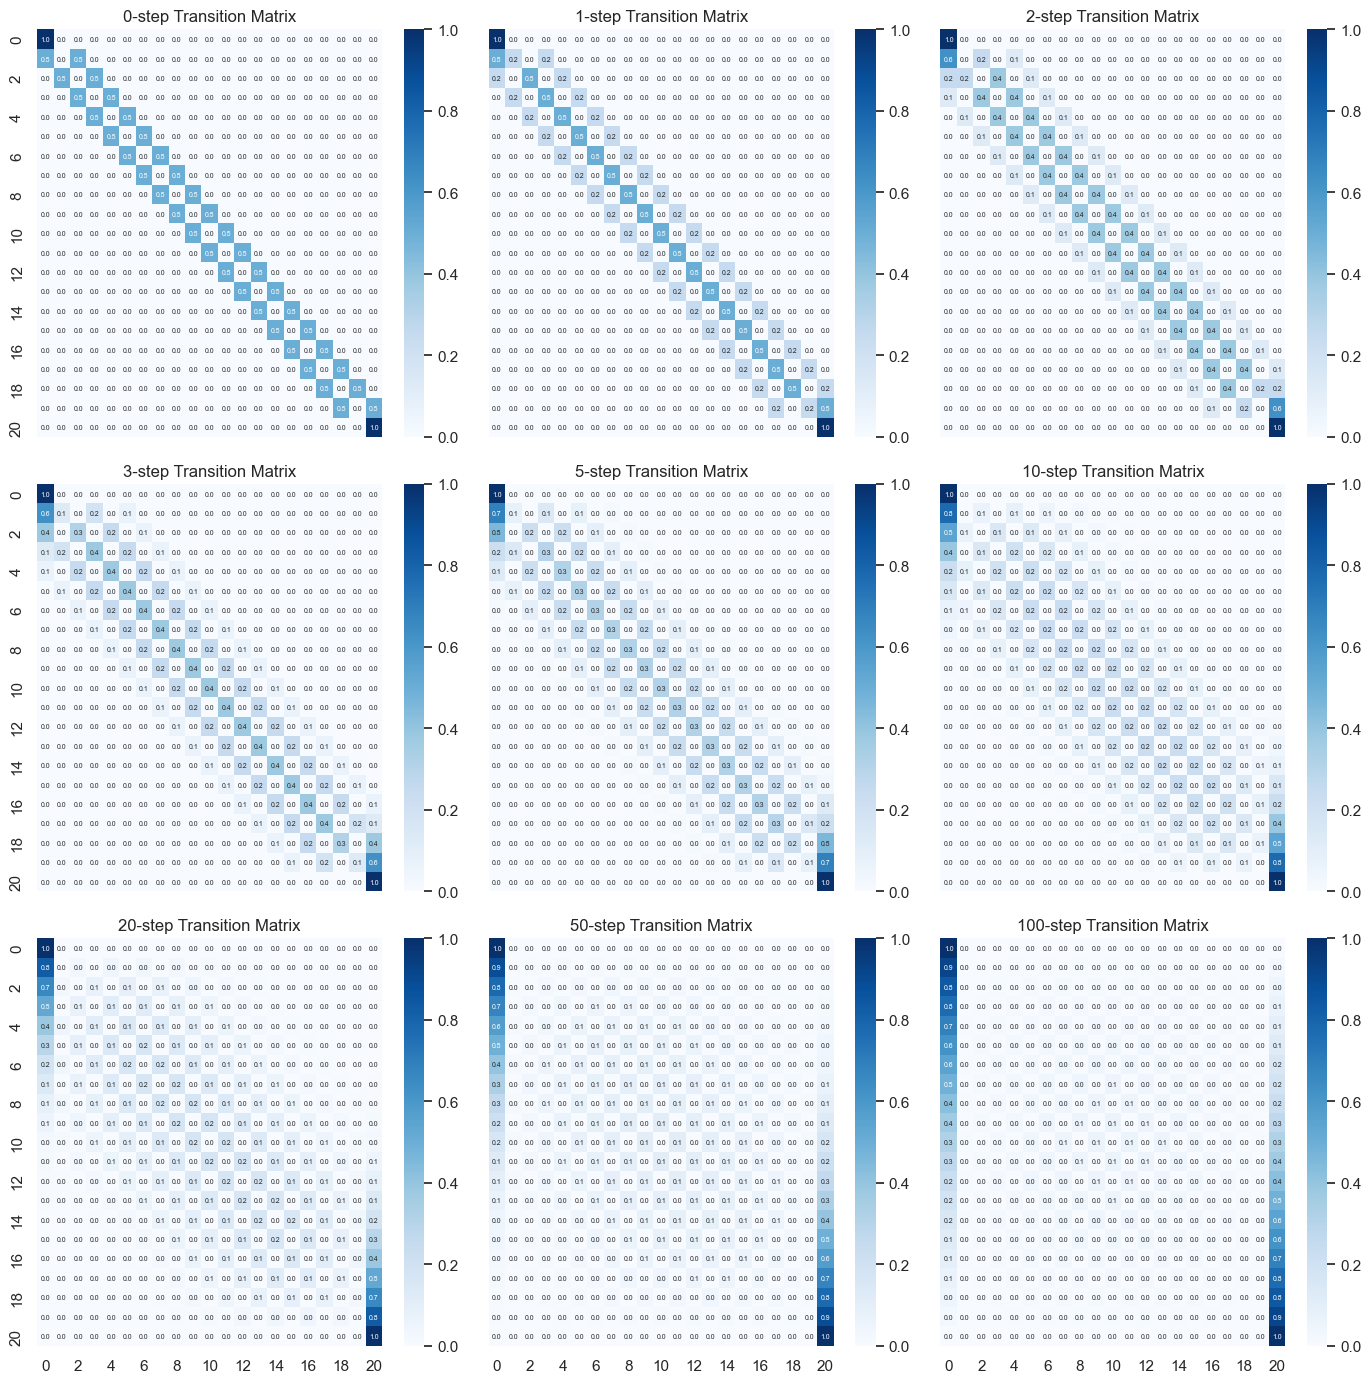

In [34]:
nstep_matrix(nstep_probability_50)

The probability in state 0 or state 20 becomes higher.